In [1]:
import numpy as np
from tqdm.notebook import tqdm
from scipy.stats   import norm
from scipy.stats   import poisson
from matplotlib    import pyplot  as plt
from matplotlib.offsetbox import AnchoredText

# 1. A gaussian integral

Using Monte Carlo integration, check that

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = 2\sigma^4 .$$

- Does the result converge with the number of samples? And how does the error go down?
- Do it many times. For a given $N$, how are the result distributed? We'll talk about model fitting at lenght later on, but for now try to fit it by hand with a parametrized model. (If N is large enough you should get something that looks *very* accurate! And if $N$ is small?)
- How does the distribution change if $N$ increases?

Looking at the integral I can see something similar to a Gaussian distribution. <br>
In fact,
$$
p(x|\mu,\sigma) = p(x|0,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} exp \left(-\frac{x^2}{2\sigma^2}\right)
$$
but since the integral is between $0$ and $\infty$, the pdf shall be
$$
p(x)= \frac{2}{\sigma\sqrt{2\pi}} exp \left(-\frac{x^2}{2\sigma^2}\right)
$$
which is a half-Gaussian with the correct normalization at $\int_0^\infty p(x) = 1$. <br>
So, now, I can write the integral as
$$
I = \sigma\frac{\sqrt{2\pi}}{4}\int_0^\infty x^3 p(x) \,dx = 2\sigma^4
$$
To do a Monte-Carlo integration, I need to sample from the distribution $p(x)$ and evaluate it in $x^3$. The final result will be
$$
I_{MC} = \sigma\frac{\sqrt{2\pi}}{4} \frac{\Sigma x_i^3}{N}
$$
with $x_i$ that are the samples from $p(X)$.

In [2]:
# Choose how many samples we want
N = 10**4

# Choose the sigma
sigma = 2

# Initialize a Gaussian distribution object
gaussian = norm( loc=0, scale=sigma)

# To compute half of a Gaussian, I can simply take the absolute value
# NB the .rvs method extract N samples from the gaussian pdf
half_g = np.abs(gaussian.rvs(N))

# Compute the integral
I_MC = sigma * np.sqrt(2*np.pi) /2 /N * np.sum(half_g**3)

# Compute the 'true' value of the integral as 2*sigma^4
I    = 2 * sigma**4

# Compute the relative error, which is the absolute error normalized by the true value
error = np.abs(I_MC - I) / I

# Print the results
print('The true value of the integral is: ', I, '\nThe Monte-Carlo value of the integral is: ', I_MC, '\nThe relative error is ', error)

The true value of the integral is:  32 
The Monte-Carlo value of the integral is:  31.92727633961892 
The relative error is  0.0022726143869087334


Now, let's see what happen if we increase the number of samples sampled

In [3]:
# I write in function the expressions above
def I_MC (N, sigma):
    gaussian = norm( loc=0, scale=sigma)
    half_g = np.abs(gaussian.rvs(N))
    return sigma * np.sqrt(2*np.pi) /2 /N * np.sum(half_g**3)

def I_true (sigma):
    return 2 * sigma**4

def error (i, i_mc):
    return np.abs(i_mc - i)/i

0it [00:00, ?it/s]

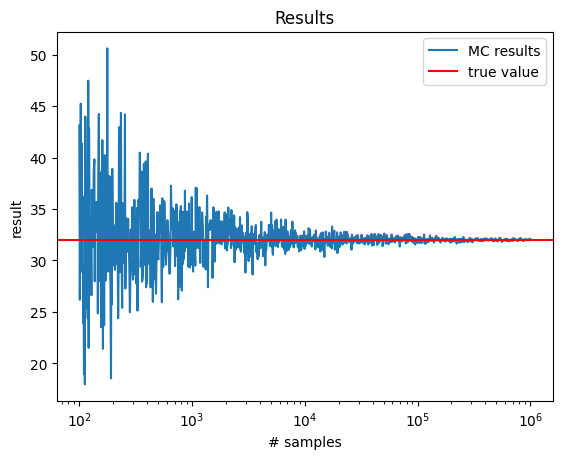

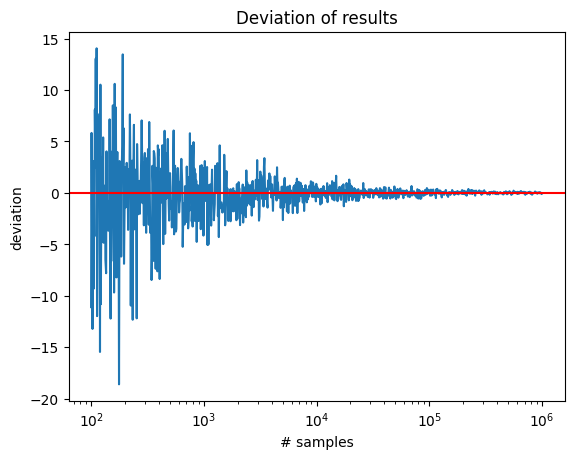

In [4]:
# Define the range of samples, the sigma, and an empty array for the results and errors
N_val   = np.rint(np.logspace(2, 6, 1000)).astype(int)
sigma   = 2
results = []
rel_err = []

# Compute the true value of the integral
true_result = I_true(sigma)

# Loop and compute the MC integral
for i, val in tqdm(enumerate(N_val)):
    results.append(I_MC(val,sigma))
    rel_err.append(error(true_result,results[i]))

# Plot the trend for N
plt.plot(N_val, results, label='MC results')
plt.axhline(true_result, c='red', label='true value')
plt.xlabel('# samples')
plt.ylabel('result')
plt.xscale('log')
plt.title('Results')
plt.legend()
plt.show()

# Plot the trend for the deviation between the results
plt.plot(N_val, true_result - np.array(results))
plt.axhline(0, c='red')
plt.xlabel('# samples')
plt.ylabel('deviation')
plt.xscale('log')
plt.title('Deviation of results')
plt.show()

I expect the errors to follow a trend like $\sim1/\sqrt{N}$. <br>
This is because the result of a Monte Carlo integration is computed as a sample arithmetic mean.
So its error must scale as $\sim1/\sqrt{N}$
 wher$e$ N is the number of sampl.es

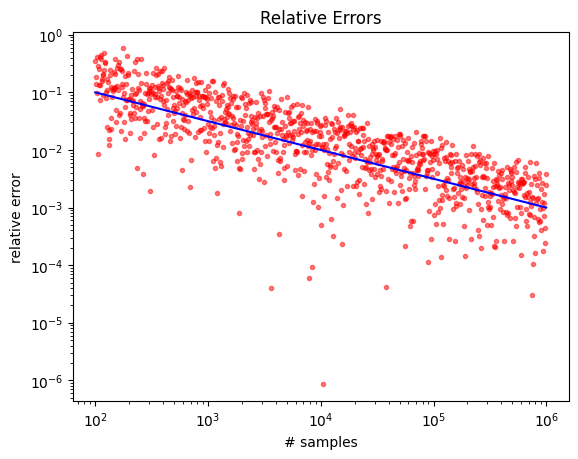

In [5]:
# Plot the trend for the error
plt.scatter(N_val, rel_err, c='red', marker='.', alpha=0.5)
plt.plot(N_val, N_val**-0.5, c='b')
plt.xlabel('# samples')
plt.ylabel('relative error')
plt.xscale('log')
plt.yscale('log')
plt.title('Relative Errors')
plt.show()

Fixing the number of samples and the standard deviation, we can look at how the results are distribuited.

In [6]:
N = np.arange(10**3,10**5,5*10**3)
sigma = 2

realizations = []
for n in tqdm(N):
    realizations.append(np.array([I_MC (n, sigma) for i in range(10**4)]))

  0%|          | 0/20 [00:00<?, ?it/s]

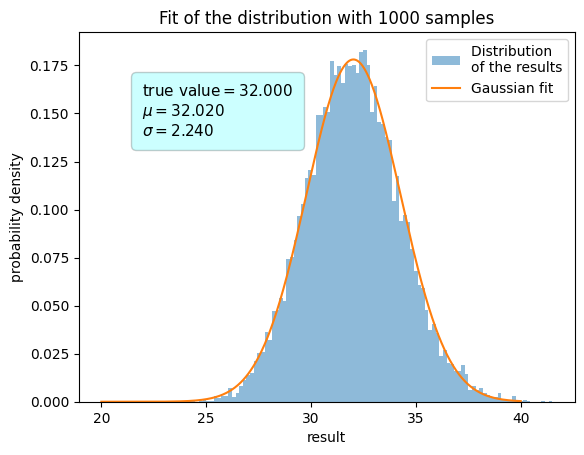

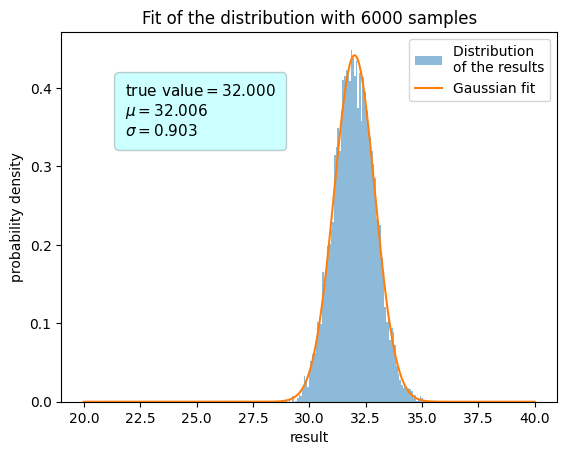

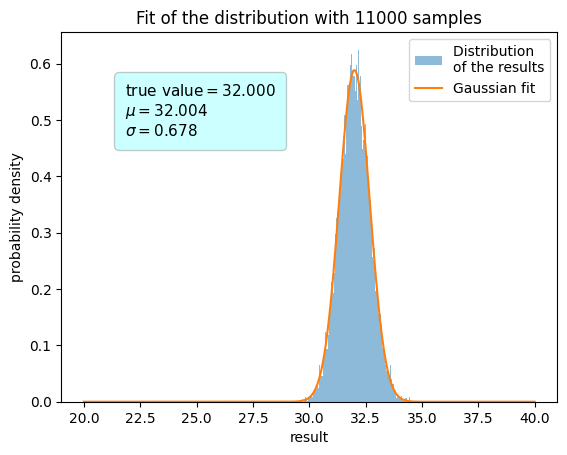

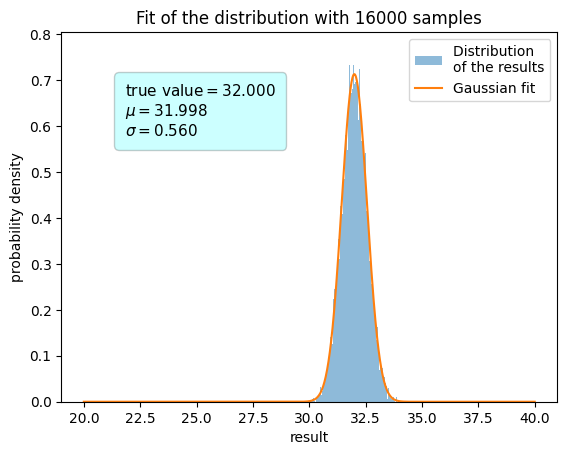

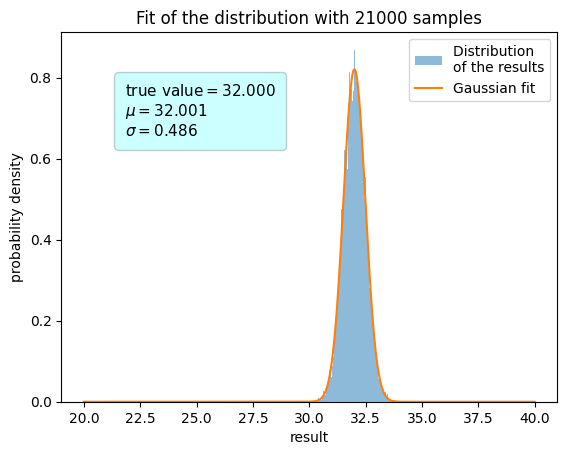

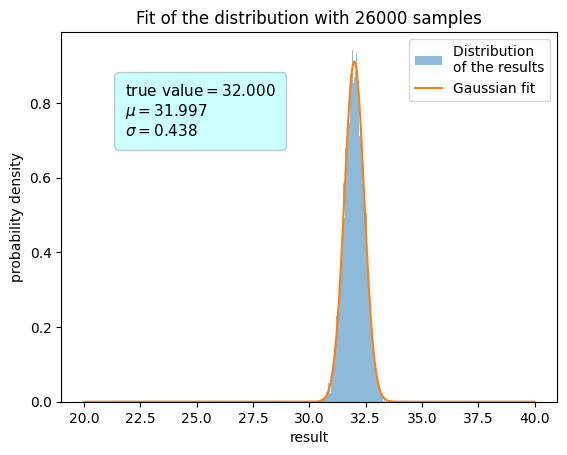

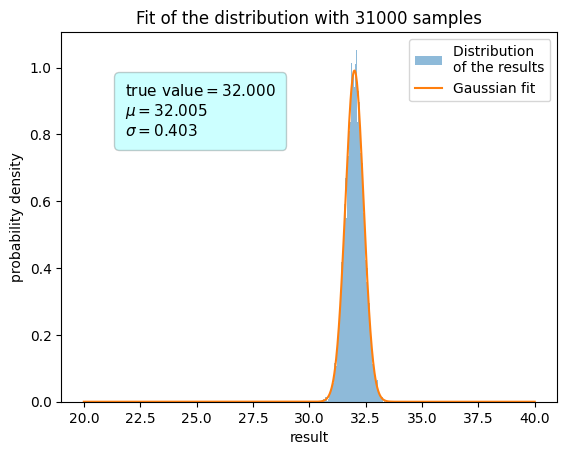

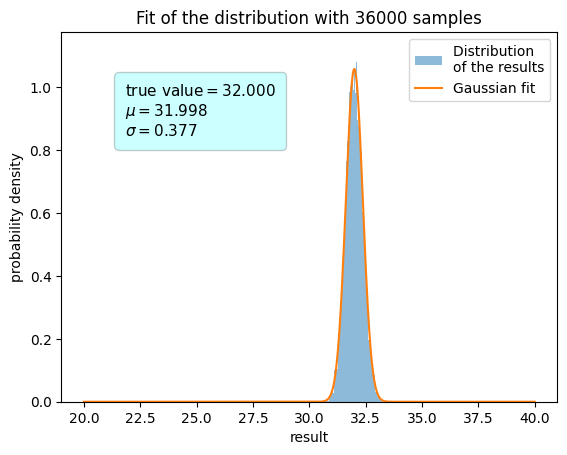

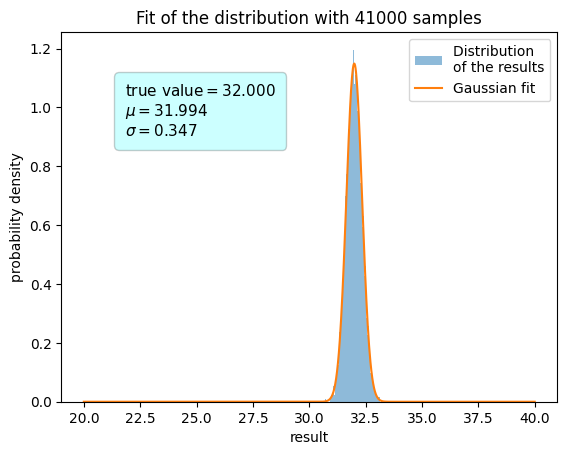

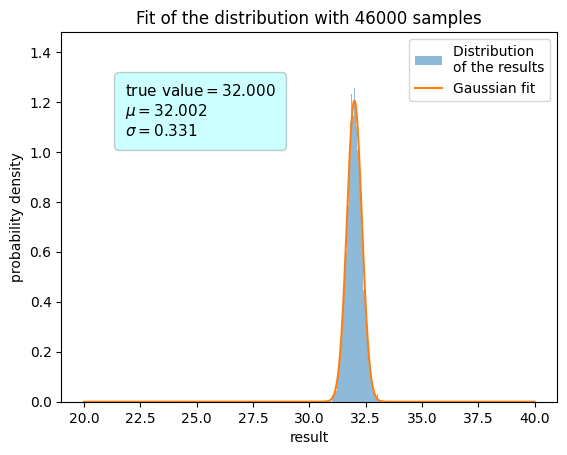

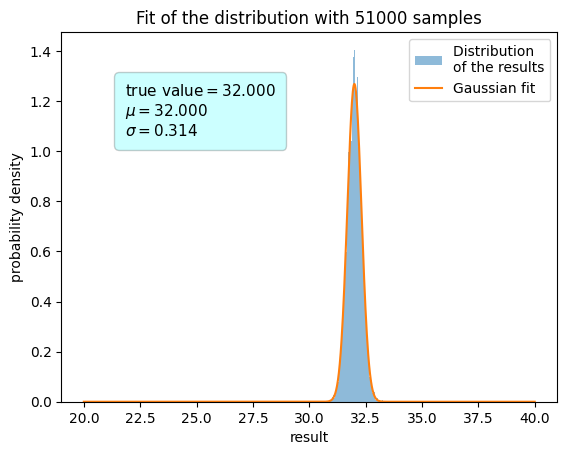

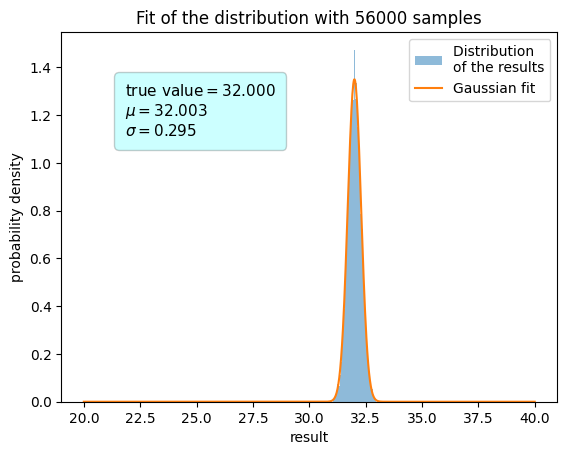

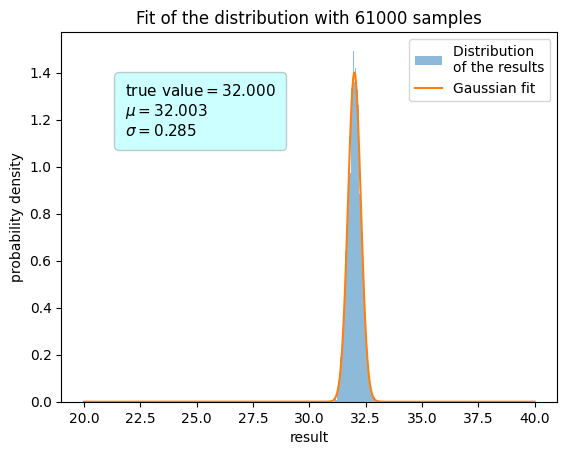

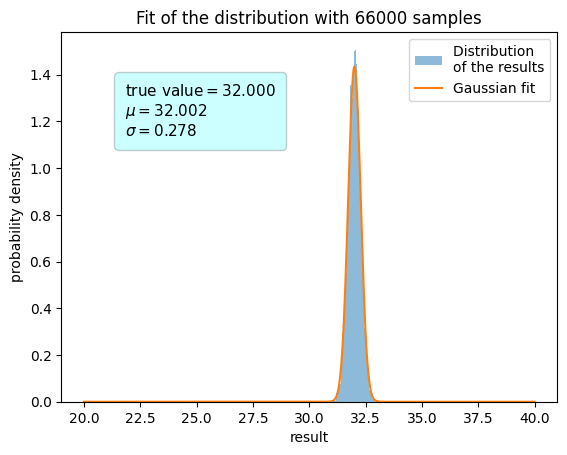

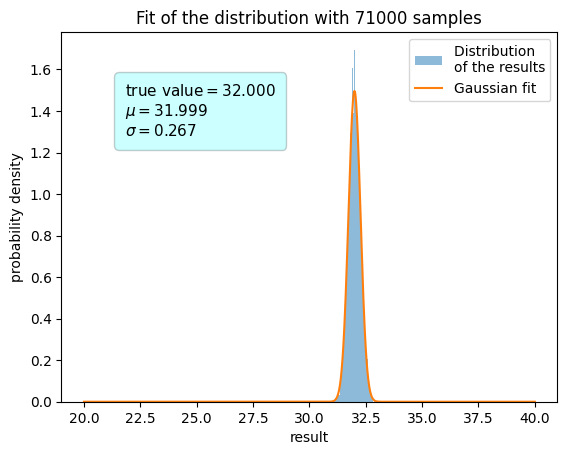

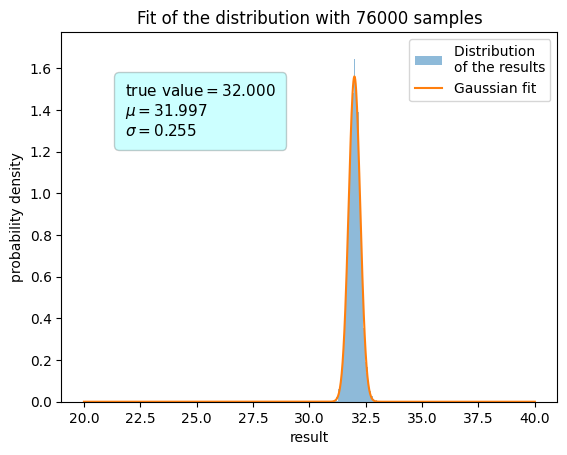

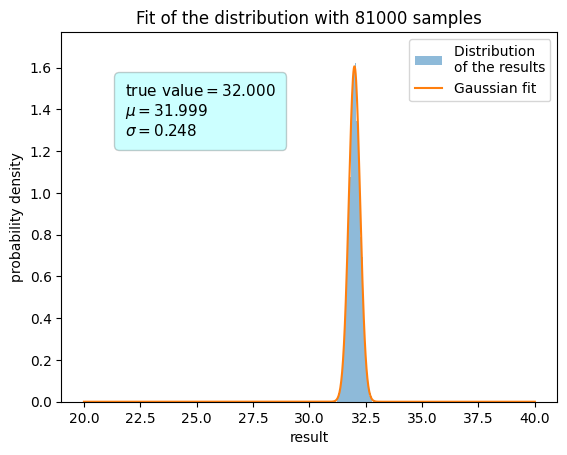

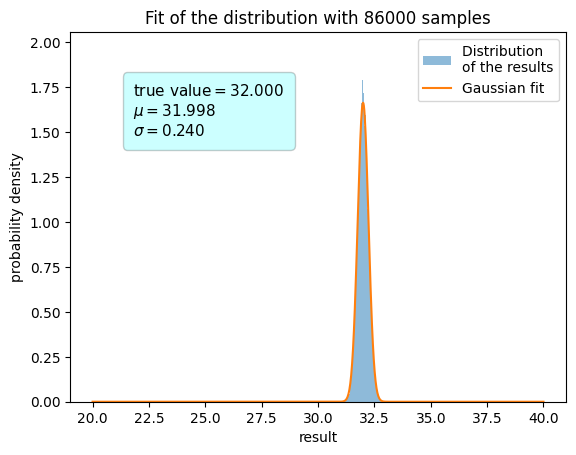

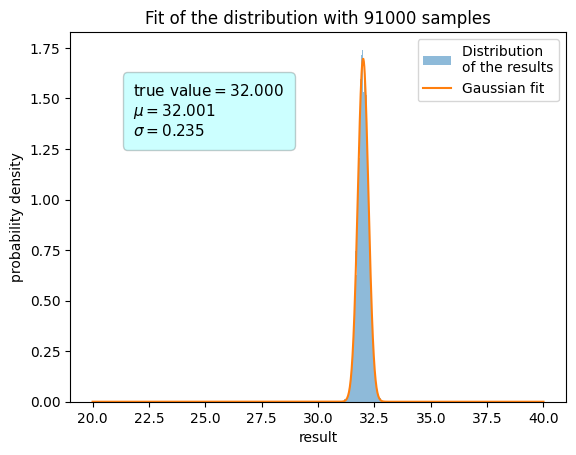

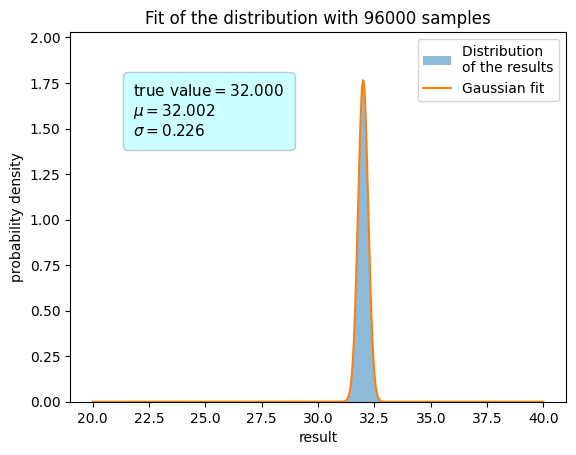

In [7]:
# Plot the instagram of the results
for realizations_, n in zip(realizations, N):
    plt.hist(realizations_, bins=100, density=True, label='Distribution \nof the results', alpha=0.5)
    plt.xlabel('result')
    plt.ylabel('probability density')

    # Fit it with a Gaussian, with mu=mean and sigma=std of the sample
    mean  = np.mean(realizations_)
    # NB I need to compute the std with a 1 degree of freedom less
    #    because I needed it to compute the mean. But N is so large that I could ignore the Bessel's correction
    std   = np.std(realizations_, ddof=1)
    gauss = norm(loc=mean, scale=std)
    x = np.linspace(20,40,1000)
    plt.plot(x, gauss.pdf(x), label='Gaussian fit')
    textstr = '\n'.join((
    r'$\text{true value}=%.3f$' %(I_true(sigma)),
    r'$\mu=%.3f$' % (mean, ),
    r'$\sigma=%.3f$' % (std, )))
    anchored_text = AnchoredText(textstr, loc='upper left', prop=dict(size=11), frameon=True, 
                             bbox_to_anchor=(0.1, 0.9), bbox_transform=plt.gca().transAxes)
    anchored_text.patch.set_boxstyle('round')
    anchored_text.patch.set_facecolor('cyan')
    anchored_text.patch.set_alpha(0.2)
    plt.gca().add_artist(anchored_text)
    plt.title('Fit of the distribution with '+str(n)+' samples')
    plt.legend()
    plt.show()

I can see that increasing the number of $N$ means that the distribution will be more peaked around the real result. This is because the $\sigma$ is decreasing. <br>
So, the distribution is more centered around the real value, with a larger $N$ we can have a better estimation of the real value of the integral.

# 2. Kicking horses

A famous early  application of low-number statistics was an analysis of Prussian cavalryman horse-kick deaths by [Bortkiewicz](https://www.wikiwand.com/en/Ladislaus_Bortkiewicz) in 1898.

He studied the distribution of 122 men kicked to death by horses among 10 Prussian army corps within 20 years (so a total number of corpes of 200). He recorded the number of corps with a given number of deaths:

| Number of deaths | Number of groups |
| --- | --- |
| 0 | 109 |
| 1 | 65 |
| 2 | 22 |
| 3 | 3 |
| 4 | 1 |

- Plot the resulting probability distribution. Careful with the normalization
- How does it look like? Again try to fit it by hand.

(Hint: think about sample mean and sample variance)


In [8]:
deaths = np.array([0,1,2,3,4])
groups = np.array([109,65,22,3,1])

I need to normalize the results to obtain a probability. Since they are discrete, I can use the simplest definition of probability and divide them for the total number of corpers.

In [9]:
groups_normalized = groups / 200

Since it is a low number statistic, I imagine to use a Poisson distribution. <br>
So, I need to know what is the known constant mean of events occourring in a fixed period of time

In [10]:
mu = np.average(deaths, weights=groups_normalized)
print('The mean is ', mu)

# Now, I build the Poisson distribution object
poisson_dist = poisson.pmf(deaths, mu = mu)

The mean is  0.6100000000000001


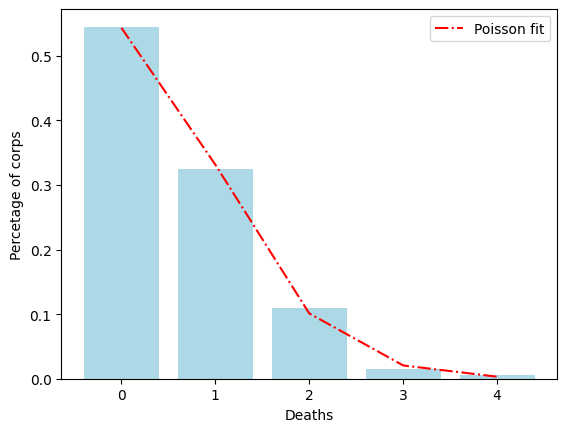

In [11]:
plt.bar(deaths, groups_normalized, color = 'lightblue')
plt.plot(deaths, poisson_dist , color='r', ls='-.', label='Poisson fit')
plt.xlabel('Deaths')
plt.ylabel('Percetage of corps')
plt.legend()